## Assignment2

### BT3041 – Analysis and Interpretation of Biological Data
---
### Name: Utkarsh Kumar
### Roll No: ME17B123

In [18]:
# import necessary libraries
from copy import deepcopy
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import train_test_split

## Template Classes

In [2]:
class AutoDiffFunction():
    """Format for any function in general which has to be auto-differentiable
    """

    def __init__(self, *args, **kwds) -> None:
        self.saved_for_backward = {} # caching to save computation
        self.grad = {} # holds gradients

    def __call__(self, *args, **kwds):
        
        # performs one forward and backward pass in each call
        output = self.forward(*args, **kwds)
        self.grad = self.compute_grad(*args, **kwds)
        return output

    def forward(self, *args, **kwds):
        """Calculates a forward pass
        """
        pass

    def compute_grad(self, *args, **kwds):
        """Computes local gradient of that function itself w.r.t its input
        """
        pass

    def backward(self, *args, **kwds):
        """Computes actual gradient w.r.t. the loss after chained gradients ahead 
            of the function till the loss are passed 
        """
        pass


class Layer(AutoDiffFunction):
    """Format to create your own custom layer for the model
    """
    def __init__(self, *args, **kwds) -> None:
        super().__init__(*args, **kwds)

        self.weights = {} # holds weights of the layer
        self.optimizer = None # optimizer for the layer

    def initialize_weights(self, *args, **kwds):
        """Initialize weights for the layer
        """
        pass

    def update_weights(self):
        """Updates weights of the layer using layer's assigned optimizer
        """
        self.optimizer.step(self)


class Loss(AutoDiffFunction):
    """Format to create a custom loss function
    """

    def forward(self, y_true, y_pred):
        """Calculates a forward pass
        """
        pass 

    def backward(self):
        """Computes actual gradient w.r.t. the loss after chained gradients ahead 
            of the function till the loss are passed 
        """
        return self.grad["x"]

    def compute_grad(self, y_true, y_pred):
        """Computes local gradient of that function itself w.r.t its input
        """
        pass


class Optimizer():
    """Format to create a custom optimizer
    """
    def __init__(self, *args, **kwds):
        self.remember = {} # remembering parameters from last iteration
        pass

    def step(self, layer):
        """Performs the update step for weights of the optmizer

        Args:
            layer: Layer object assigned to the optimizer 
        """
        pass    

## Activation Functions

For this assignment we implement the following activation functions:

1. Sigmoid activation

$$y = \sigma(x) = \frac{1}{1 + e^{-x}}$$

$$\frac{dy}{dx} = \frac{-e^{-x}}{(1 + e^{-x})^2} = \sigma(x)(1 - \sigma(x))$$

2. ReLU activation

$$y = ReLU(x) = max(0, x)$$

$$ \frac{dy}{dx} = \left\{
\begin{array}{ll}
      1 & x\geq 0\\
      0 & x\leq 0 \\
\end{array} 
\right.$$


In [3]:
class Sigmoid(AutoDiffFunction):
    """ 
    Represents the Sigmoid Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = 1/(1 + np.exp(-x))
        return self.saved_for_backward

    def compute_grad(self, x):
        y = self.saved_for_backward

        return {"x": y*(1-y)}

    def backward(self, dy):
        return dy * self.grad["x"]      


class RelU(AutoDiffFunction):
    """ 
    Represents the RelU Activation function
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x):
        self.saved_for_backward = np.where(x>0.0, 1.0, 0.0)

        return x * self.saved_for_backward

    def compute_grad(self, x):
        return {"x": self.saved_for_backward}

    def backward(self, dy):
        return dy * self.grad["x"]

## Layers

For this assignment, we only use fully connected OR Dense layers where each input neuron is connected to each output neuron, along with a bias unit.

The equation for such a layer is simply

$$y = FullyConnected(x) = wx + b$$

$$\frac{dy}{dw} = x^T \quad\frac{dy}{dx} = w^T  \quad\frac{dy}{db} = 1$$

<br><br>
Note: We have also created the fully connected layer such that the weights can be initialized 2 different ways


In [4]:
class FC(Layer):
    def __init__(self, in_dim, out_dim, weight_decay=None, init_method="xavier") -> None:
        super().__init__()
        self.weight_decay = weight_decay
        self.init_method = init_method
        self.initialize_weights(in_dim, out_dim)

    def initialize_weights(self, in_dim, out_dim):
        
        if self.init_method == "random":
            scaling_factor = 1/np.sqrt(in_dim)
            self.weights["w"] = np.random.randn(in_dim, out_dim) * scaling_factor
            self.weights["b"] = np.random.randn(1, out_dim) * scaling_factor
        elif self.init_method == "xavier":
            lim = np.sqrt(6 / (in_dim + out_dim))
            self.weights["w"] = np.random.uniform(low=-lim, high=lim, size=(in_dim, out_dim))
            self.weights["b"] = np.random.uniform(low=-lim, high=lim, size=(1, out_dim))

    def compute_grad(self, x):
        
        gradients = {}

        # y = x * w + b        
        # we compute gradients wrt w and x 
        # gradient wrt b is not required explicitly since we know that it's value is 1
        gradients["w"] = self.saved_for_backward["x"].T
        gradients["x"] = self.weights["w"].T

        return gradients


    def forward(self, x):
        output = x @ self.weights["w"] + self.weights["b"]
        self.saved_for_backward["x"] = x
        
        return output

    def backward(self, dy):
        
        # calculating gradients wrt input to pass on to previous layer for backprop
        dx = dy @ self.grad["x"]
        
        # calculating gradients wrt weights
        dw = self.grad["w"] @ dy
        db = np.sum(dy, axis=0, keepdims=True)

        # accomodating for weight_decay / L2 regularization
        if self.weight_decay:
            dw = dw + 2 * self.weight_decay * self.weights["w"]
            db = db + 2 * self.weight_decay * self.weights["b"]

        self.absolute_gradients = {"w": dw, "b": db}

        return dx

    def update_weights(self):
        self.optimizer.step(self)

## Loss Functions



#### CrossEntropy Loss

$$L(p, y) = \Sigma_{i=1}^{N} \Sigma_{k=1}^{K} y_{ik} \log p_{ik}$$ 

where $$y_{ik} = \left\{
\begin{array}{ll}
      1 & x \in class-k\\
      0 & else \\
\end{array} 
\right.$$

$p_{ik} =$ probability that $i^{th}$ sample falls in $k^{th}$ class

#### Softmax function.

$ f: [x_1, x_2, ... x_k] \rightarrow [p_1, p_2, ... p_k]$ such that $p_i = \frac{e^{x_i}}{\Sigma_{k=1}^{K} e^{x_i}}$

To find the derivative of loss w.r.t input we have apply the chain rule. Let $p(x)$ represent the softmax activation and $L$ represent the loss. Then the expression turns out to be:

$$\frac{\partial L}{\partial x} = \frac{\partial L(p, y)}{\partial p} \frac{\partial p(x)}{\partial x} = p - y$$

In [5]:
# CROSSENTROPY LOSS
class CrossEntropyLossFromLogits(Loss):
    def __init__(self) -> None:
        super().__init__()
        self.n_classes = None

    @staticmethod
    def softmax(x):
        v = np.exp(x)
        return v / np.sum(v, axis=1, keepdims=True)

    def encode(self, y): 
        encoded_y = np.zeros(shape=(len(y), self.n_classes))

        for i in range(len(y)):
            encoded_y[i,y[i]] = 1

        return encoded_y

    def forward(self, y_pred, y_true):
         
        probabilities = self.softmax(y_pred)
        y_true_encoded = self.encode(y_true)

        loss_value = np.mean(np.sum(- y_true_encoded * np.log(probabilities), axis=1))

        self.saved_for_backward["probabilities"] = probabilities
        self.saved_for_backward["y_true"] = y_true_encoded

        return loss_value

    def compute_grad(self, y_pred, y_true):

        return {"x": self.saved_for_backward["probabilities"] - self.saved_for_backward["y_true"]}        


## Optimizers/ Learning algorithm

Optimizers basically denote how to make use of the gradients achieved through backpropogation to update the weights of the model. The following optimizers are used in this notebook, all made from scratch

1) SGD<br>
2) Momentum based gradient descent<br>
3) Adam<br>

All the default parameter values are taken from keras optimizers.

In [6]:
# 1. SGD OPTIMIZER
class SGD(Optimizer):
    def __init__(self, lr=1e-2):
        super().__init__()
        self.lr = lr

    def step(self, layer):

        for weight_name, _ in layer.weights.items():
            layer.weights[weight_name] = layer.weights[weight_name] - self.lr * layer.absolute_gradients[weight_name]
            

# 2. MOMENTUM OPTIMIZER
class Momentum(Optimizer):
    def __init__(self, lr=1e-3, gamma=0.9):
        super().__init__()
        self.lr = lr
        self.gamma = gamma
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
        
        #Momentum update rule
        for weight_name, weight in layer.weights.items():
            self.remember[weight_name]["v"] = self.gamma * self.remember[weight_name]["v"] + \
                                                self.lr * layer.absolute_gradients[weight_name]
            layer.weights[weight_name] = layer.weights[weight_name] - self.remember[weight_name]["v"]

            
            
# 3. ADAM OPTIMIZER
class Adam(Optimizer):
    def __init__(self, lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        super().__init__()
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.t = 1
        
    def step(self, layer):
        
        #Initialise update history
        if self.remember == {}:
            for weight_name, weight in layer.weights.items():
                self.remember[weight_name] = {}
                self.remember[weight_name]["v"] = np.zeros_like(weight)
                self.remember[weight_name]["m"] = np.zeros_like(weight)
        
        #Adam update rule
        for weight_name, weight in layer.weights.items():
            
            #Update m_t and v_t
            self.remember[weight_name]["m"] = self.beta_1 * self.remember[weight_name]["m"] + \
                                                (1 -self.beta_1) * layer.absolute_gradients[weight_name]
            
            self.remember[weight_name]["v"] = self.beta_2 * self.remember[weight_name]["v"] + \
                                                (1 - self.beta_2) * (layer.absolute_gradients[weight_name]**2)
            
            #Bias correction
            m_hat = self.remember[weight_name]["m"]/(1 - self.beta_1 ** self.t)
            v_hat = self.remember[weight_name]["v"]/(1 - self.beta_2 ** self.t)
            
            #Update parameters
            layer.weights[weight_name] = layer.weights[weight_name] - (self.lr / (np.sqrt(v_hat + self.epsilon))) * m_hat
            
        self.t += 1

## Framework for the Neural Network

In [7]:
class NeuralNet():
    def __init__(self, layers) -> None:
        self.layers = layers
        self.history = []

    def __call__(self, *args, **kwds):
        return self.forward(*args, **kwds)

    def compile(self, loss, optimizer):
        self.loss = loss

        for layer in self.layers:
            if isinstance(layer, Layer):
                layer.optimizer = deepcopy(optimizer) # each layer has it's own optimizer

    def forward(self, x):
        """Performs forward pass for the entire network

        Args:
            x (np.ndarray): input array

        Returns:
            np.ndarray: output of the neural network
        """
        for layer in self.layers:
            x = layer(x)

        return x

    def backward(self):
        """Performs one backward pass for the entire network
            and saves the gradients

        Returns:
            np.ndarray: gradient of the 1st layer
        """

        gradient = self.loss.backward()
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

        return gradient

    def update_weights(self):
        """Updates weights of all layers using the chosen optimizer 
            and saved gradients
        """

        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                layer.update_weights()

    @staticmethod
    def accuracy_score(y_pred, y_true):
        """Returns accuracy score

        Args:
            y_pred (np.ndarray): predicted labels (batch_size X n_classes)
            y_true (np.ndarray): true labels (batch_size X 1)

        Returns:
            [float]: accuracy in fraction
        """

        pred_labels = np.argmax(y_pred, axis=1)
        return np.sum(pred_labels == y_true) / len(y_true)

    @staticmethod
    def create_batches(X, y, batch_size=32):
        """Creates batches from given dataset of given size

        Args:
            X (np.ndarray): input features
            y (np.ndarray): labels
            batch_size (int, optional): batch size. Defaults to 32.

        Returns:
            list: batches of data as list of (x,y) tuples
        """
        batches = []

        for i in range(len(y) // batch_size):
            start_idx = batch_size * i
            end_idx = batch_size * (i + 1)

            batches.append([X[start_idx: end_idx], y[start_idx: end_idx]])

        # take care of the last batch which might have batch_size less than the specified one
        if len(y) % batch_size != 0:
            batches.append([X[end_idx:], y[end_idx:]])

        return batches

    def fit(self, X_train, y_train, X_val, y_val, batch_size=32, epochs=10):
        """Fits the model onto the given data

        Args:
            X_train (np.ndarray): train features
            y_train (np.ndarray): train labels
            X_val (np.ndarray): validation features
            y_val (np.ndarray): validation labels
            batch_size (int, optional): batch size. Defaults to 32.
            epochs (int, optional): number of epochs to train the model. Defaults to 10.
        """

        # calculate number of classes to pass to the loss function
        self.loss.n_classes = len(np.unique(y_train))

        train_batches = self.create_batches(X_train, y_train, batch_size=batch_size)
        val_batches = self.create_batches(X_val, y_val, batch_size=batch_size)

        num_train_batches = len(train_batches)
        num_val_batches = len(val_batches)

        for epoch in range(1, epochs+1):

            total_train_loss = 0
            total_train_accuracy = 0

            ## TRAINING ##
            for X, y in train_batches:

                preds = self(X)
                total_train_loss += self.loss(preds, y)
                total_train_accuracy += self.accuracy_score(preds, y)

                _ = self.backward()
                self.update_weights()

            train_loss_per_epoch = total_train_loss / num_train_batches
            train_accuracy = total_train_accuracy / num_train_batches

            total_val_loss = 0
            total_val_accuracy = 0

            ## VALIDATION ##
            for X_v, y_v in val_batches:
                val_preds = self(X_v)
                total_val_loss += self.loss(val_preds, y_v)
                total_val_accuracy += self.accuracy_score(val_preds, y_v)
            
            val_loss_per_epoch = total_val_loss / num_val_batches
            val_accuracy = total_val_accuracy / num_val_batches
            
            print(f"Epoch: {epoch} Train Loss: {train_loss_per_epoch} Train Accuracy: {train_accuracy} Val Loss: {val_loss_per_epoch} Val Accuracy: {val_accuracy}")

            self.history.append({"Epoch" : epoch, 
                                    "Train Loss": train_loss_per_epoch,
                                    "Train Accuracy": train_accuracy,
                                    "Val Loss": val_loss_per_epoch,
                                    "Val Accuracy": val_accuracy})

        print("\nModel trained successfully!\n")

    def evaluate(self, X_test, y_test):
        """Evaluates the model on a test dataset

        Args:
            X_test (np.ndarray): test features 
            y_test (np.ndarray): test labels
        """

        preds = self(X_test)
        test_loss = self.loss(preds, y_test)
        accuracy = self.accuracy_score(preds, y_test)

        print(f"Test loss: {test_loss} Test accuracy: {accuracy}")

# Using the framework on MNIST Dataset

In [8]:
# load mnist dataset
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#NOTE
#tensorflow has only been used to load the data and not for any other application. 
#This has been done to avoid additional lines of code where data has to be split up in 
#x_train, x_test etc... 

import pickle  # a brief on how to load data in pickle format 
with open('mnist_data.pkl', 'rb') as d:
    data=pickle.load(d)

# scaling the images by diving with 255 because 255*255 colours are possible
x_train, x_test = x_train / 255.0, x_test / 255.0

print(f"Training samples: {len(x_train)} Test samples: {len(x_test)}")

Training samples: 60000 Test samples: 10000


In [9]:
# Utility functions to preprocess image data and plotting

def flatten(arr):
    arr = arr.reshape(arr.shape[0], -1)
    return arr


def plot_labels(data, labels, class_names, flatten=False):

    uniq_labels = np.unique(labels)

    fig, ax = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = ax.reshape(-1)

    for i, label in enumerate(uniq_labels):

        img = data[np.where(labels == label)[0][0]]

        ax[i].set_title(class_names[label])
        
        if flatten:
            img = img.reshape(28, 28)

        ax[i].imshow(img)
    
    plt.show()

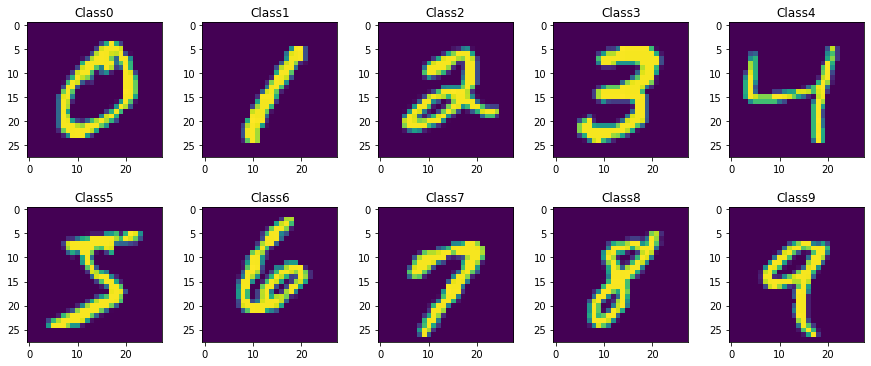

In [10]:
# plotting one image of each class
plot_labels(x_train, y_train, class_names=["Class"+str(i) for i in range(10)], flatten=True)

In [11]:
## Flatten all images into vectors ##
x_train = flatten(x_train)
x_test = flatten(x_test)

In [12]:
def train_and_evaluate_model(activation, optimizer, epochs=10):
    ## Creating an instance of the model ##
    model = NeuralNet([FC(784, 128), deepcopy(activation),
                    FC(128, 128), deepcopy(activation),
                    FC(128, 128), deepcopy(activation),
                    FC(128, 128), deepcopy(activation),
                    FC(128, 10)])

    ## Compiling the model with the loss and optimizer chosen ##
    model.compile(loss=CrossEntropyLossFromLogits(), optimizer=optimizer)

    ## Training the model (TEST RUN) ##
    model.fit(x_train, y_train, x_test, y_test, batch_size=128, epochs=epochs)
    return model


def perform_hyperparameter_tuning(paramter_dict):
    models_list = []

    for i, config in enumerate(list(ParameterGrid(paramter_dict))):
        print(f"Model {i+1}\n")
        print("-"*100,"\n")
        model = train_and_evaluate_model(**config)
        models_list.append(model)

    # Sorting it by validation accuracy best models first
    return models_list

In [13]:
params = { "activation": [RelU(), Sigmoid()],
          "optimizer": [SGD(lr=1e-3), Momentum(), Adam()] # default sgd learning rate is too fast 

}

models = perform_hyperparameter_tuning(params)

Model 1

---------------------------------------------------------------------------------------------------- 

Epoch: 1 Train Loss: 0.4755324445777495 Train Accuracy: 0.8528784648187633 Val Loss: 0.22647755031875405 Val Accuracy: 0.9275118670886076
Epoch: 2 Train Loss: 0.16730586283416768 Train Accuracy: 0.9500599680170576 Val Loss: 0.1553234407051527 Val Accuracy: 0.9522349683544303
Epoch: 3 Train Loss: 0.11722765384462461 Train Accuracy: 0.9651907871357499 Val Loss: 0.12508168808688877 Val Accuracy: 0.9613330696202531
Epoch: 4 Train Loss: 0.08893249312575023 Train Accuracy: 0.9735529939587776 Val Loss: 0.10283207156836134 Val Accuracy: 0.9685522151898734
Epoch: 5 Train Loss: 0.07005267476414678 Train Accuracy: 0.9798496357498223 Val Loss: 0.09133304211645121 Val Accuracy: 0.9716178797468354
Epoch: 6 Train Loss: 0.05611454376446505 Train Accuracy: 0.9841195806680881 Val Loss: 0.08726180548814197 Val Accuracy: 0.9730023734177216
Epoch: 7 Train Loss: 0.04463464301155377 Train Accuracy:

Epoch: 5 Train Loss: 0.12787089864782064 Train Accuracy: 0.9632584843638948 Val Loss: 0.13984657132898257 Val Accuracy: 0.9590585443037974
Epoch: 6 Train Loss: 0.10699552625611236 Train Accuracy: 0.9692719438521677 Val Loss: 0.1299151019836618 Val Accuracy: 0.9628164556962026
Epoch: 7 Train Loss: 0.09112605973966253 Train Accuracy: 0.9743192519545132 Val Loss: 0.12397156384988398 Val Accuracy: 0.9649920886075949
Epoch: 8 Train Loss: 0.07826991009418605 Train Accuracy: 0.9782171730632552 Val Loss: 0.122083953996421 Val Accuracy: 0.9647943037974683
Epoch: 9 Train Loss: 0.06736711442234485 Train Accuracy: 0.9815154140014215 Val Loss: 0.12314317581845927 Val Accuracy: 0.9646954113924051
Epoch: 10 Train Loss: 0.05797353814280666 Train Accuracy: 0.9840140813788202 Val Loss: 0.12510229308560294 Val Accuracy: 0.9644976265822784

Model trained successfully!



In [14]:
# Sorting the models according to their performances
models.sort(key=lambda x: x.history[-1]["Val Accuracy"], reverse=True)

In [15]:
# Check params for best model #
best_model_params = list(ParameterGrid(params))[2]

print("Best model activation: ", best_model_params["activation"])
print("Best model optimizer: ", best_model_params["optimizer"])

Best model activation:  <__main__.RelU object at 0x0000018A8A12DD90>
Best model optimizer:  <__main__.Adam object at 0x0000018A8A121CD0>


In [16]:
# plotting the metrics for the model #

def compare_models_plot(models):
    
    n = len(models)
    model_names = ["model_" + str(i+1) for i in range(n)]
    
    colors = ["green", "blue", "red", "brown", "violet", "yellow"]
    titles = ["Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"]
    
    fig, axs = plt.subplots(2,2, figsize=(10,10))
    fig.suptitle("Learning curve for models")
    axs = axs.reshape(-1)
    
    for i in range(4):
        
        title = titles[i]
        axs[i].set_title(title)
        
        for j in range(n):
            axs[i].plot([d["Epoch"] for d in models[j].history], 
                            [d[title] for d in models[j].history], 
                            c=colors[j], 
                            label=model_names[j])
            
        axs[i].legend()
        
    plt.show()

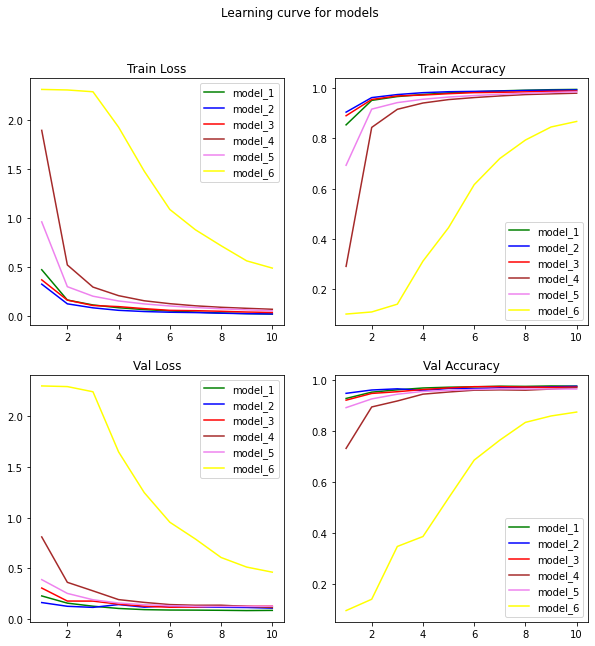

In [17]:
## Comparision of the configurations ##
compare_models_plot(models)

<p style="text-align: center">THE END<p>